In [29]:
import os
import cv2
import numpy as np
import keras
from keras.models import Sequential , Model
from keras.layers import Conv2D, MaxPool2D, Flatten, Dense, Dropout, Input
from keras import backend as K
from keras.layers import Dense, Flatten, Activation, RepeatVector, Permute, Multiply, Reshape , Softmax , Lambda
from keras.optimizers import Adam, RMSprop
from keras.callbacks import ReduceLROnPlateau
from keras.applications import VGG16
from keras.regularizers import l2
from tensorflow.keras import layers
import shap


In [30]:
img_width, img_height = 256, 256
batchsize = 32

# Load datasets
train = keras.utils.image_dataset_from_directory(
    directory=r'D:\school\pneumonia\chest_xray\chest_xray\train',
    labels='inferred',
    label_mode='categorical',
    batch_size=batchsize,
    image_size=(img_width, img_height))

validation = keras.utils.image_dataset_from_directory(
    directory=r'D:\school\pneumonia\chest_xray\chest_xray\val',
    labels='inferred',
    label_mode='categorical',
    batch_size=batchsize,
    image_size=(img_width, img_height))

test = keras.utils.image_dataset_from_directory(
    directory=r'D:\school\pneumonia\chest_xray\chest_xray\test',
    labels='inferred',
    label_mode='categorical',
    batch_size=batchsize,
    image_size=(img_width, img_height))

Found 5216 files belonging to 2 classes.
Found 16 files belonging to 2 classes.
Found 624 files belonging to 2 classes.


In [31]:


def attention_block(inputs):

    # Step 1: Dense layer for each spatial location; retains the last dimension as channels
    attention_score = Dense(1, activation='sigmoid')(inputs)

    # Step 2: Flatten the spatial dimensions to apply softmax across pixels
    shape = K.int_shape(attention_score)
    flattened_attention = Reshape((shape[1] * shape[2], shape[3]))(attention_score)  # Flatten height*width

    # Apply softmax across the flattened spatial dimensions
    attention_weights = Softmax(axis=1)(flattened_attention)

    # Reshape back to the original dimensions
    attention_weights = Reshape((shape[1], shape[2], shape[3]))(attention_weights)

    # Step 3: Broadcast the attention weights to all channels
    attention_weights = Lambda(lambda x: K.repeat_elements(x, rep=512, axis=3))(attention_weights)

    # Apply attention weights
    weighted_inputs = Multiply()([inputs, attention_weights])

    return weighted_inputs

In [32]:


def CNN_Model_with_Attention():
    base_model = VGG16(weights='imagenet', include_top=False, input_shape=(img_width, img_height, 3))
    for layer in base_model.layers:
        layer.trainable = False
    for i in range(3):
        base_model.layers[-2 - i].trainable = True

    attention_output = attention_block(base_model.output)

    flatten_layer = Flatten()(attention_output)
    dense_layer = Dense(128, activation='relu', kernel_regularizer=l2(0.05))(flatten_layer)
    final_output = Dense(2, activation='sigmoid')(dense_layer)

    model = Model(inputs=base_model.input, outputs=final_output)

    return model

In [33]:
model_with_attention = CNN_Model_with_Attention()
model_with_attention.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
model_with_attention.summary()
hist = model_with_attention.fit(train, epochs=6, validation_data=validation)

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_8 (InputLayer)        [(None, 256, 256, 3)]        0         []                            
                                                                                                  
 block1_conv1 (Conv2D)       (None, 256, 256, 64)         1792      ['input_8[0][0]']             
                                                                                                  
 block1_conv2 (Conv2D)       (None, 256, 256, 64)         36928     ['block1_conv1[0][0]']        
                                                                                                  
 block1_pool (MaxPooling2D)  (None, 128, 128, 64)         0         ['block1_conv2[0][0]']        
                                                                                              

In [34]:
best_score = max(hist.history['val_accuracy'])
print(f"Best Validation score is: {best_score}")

Best Validation score is: 1.0


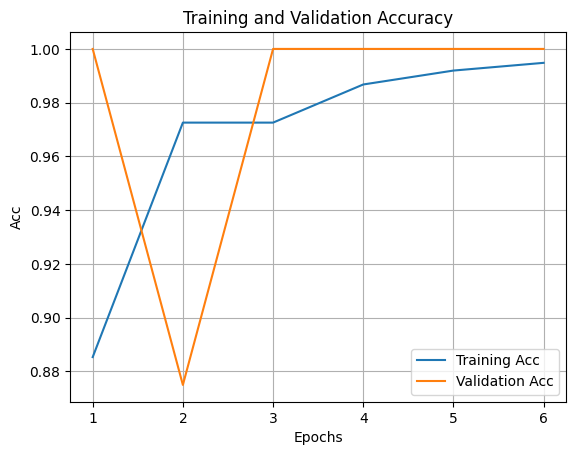

In [54]:
import matplotlib.pyplot as plt
# Extract the training and validation loss values from the history object
train_accuracy = hist.history['accuracy']
val_accuracy = hist.history['val_accuracy']

# Create a list of epoch numbers (1 to number of epochs)
epochs = range(1, len(train_accuracy) + 1)

# Plot the loss graph
plt.plot(epochs, train_accuracy , label='Training Acc')
plt.plot(epochs, val_accuracy, label='Validation Acc')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Acc')
plt.legend()
plt.grid(True)
plt.show()

In [44]:
import lime
from lime import lime_image
from skimage.segmentation import mark_boundaries


In [45]:
def get_numpy_data_from_batch(dataset):
    for images, labels in dataset.take(1):  # Only take 1 batch
        return images.numpy(), np.argmax(labels.numpy(), axis=1)
test_images, test_labels = get_numpy_data_from_batch(test)

In [46]:
explainer = lime_image.LimeImageExplainer()

In [57]:
x_test_scaled = test_images / 255

  0%|          | 0/1000 [00:00<?, ?it/s]

1/1 [==============================] - 2s 2s/step


  1%|          | 10/1000 [00:02<03:46,  4.38it/s]

1/1 [==============================] - 2s 2s/step


  3%|▎         | 29/1000 [00:04<02:06,  7.67it/s]

1/1 [==============================] - 2s 2s/step


  3%|▎         | 34/1000 [00:06<03:12,  5.02it/s]

1/1 [==============================] - 2s 2s/step


  4%|▍         | 40/1000 [00:08<03:49,  4.18it/s]

1/1 [==============================] - 2s 2s/step


  5%|▌         | 50/1000 [00:10<03:30,  4.51it/s]

1/1 [==============================] - 2s 2s/step


  6%|▌         | 60/1000 [00:12<03:20,  4.69it/s]

1/1 [==============================] - 2s 2s/step


  7%|▋         | 70/1000 [00:14<03:14,  4.79it/s]

1/1 [==============================] - 2s 2s/step


  8%|▊         | 80/1000 [00:16<03:13,  4.75it/s]

1/1 [==============================] - 2s 2s/step


  9%|▉         | 90/1000 [00:18<03:11,  4.75it/s]

1/1 [==============================] - 2s 2s/step


 10%|█         | 100/1000 [00:20<03:07,  4.80it/s]

1/1 [==============================] - 2s 2s/step


 12%|█▏        | 117/1000 [00:22<02:23,  6.14it/s]

1/1 [==============================] - 2s 2s/step


 12%|█▏        | 120/1000 [00:25<03:26,  4.25it/s]

1/1 [==============================] - 2s 2s/step


 14%|█▍        | 138/1000 [00:27<02:25,  5.91it/s]

1/1 [==============================] - 2s 2s/step


 14%|█▍        | 142/1000 [00:29<03:22,  4.24it/s]

1/1 [==============================] - 2s 2s/step


 15%|█▌        | 150/1000 [00:31<03:27,  4.10it/s]

1/1 [==============================] - 2s 2s/step


 16%|█▌        | 160/1000 [00:34<03:13,  4.34it/s]

1/1 [==============================] - 2s 2s/step


 17%|█▋        | 170/1000 [00:36<03:04,  4.51it/s]

1/1 [==============================] - 2s 2s/step


 18%|█▊        | 180/1000 [00:38<02:58,  4.60it/s]

1/1 [==============================] - 2s 2s/step


 20%|█▉        | 199/1000 [00:40<02:05,  6.39it/s]

1/1 [==============================] - 2s 2s/step


 20%|██        | 202/1000 [00:42<02:57,  4.51it/s]

1/1 [==============================] - 2s 2s/step


 21%|██        | 210/1000 [00:44<03:07,  4.22it/s]

1/1 [==============================] - 2s 2s/step


 22%|██▏       | 220/1000 [00:46<03:00,  4.31it/s]

1/1 [==============================] - 2s 2s/step


 23%|██▎       | 230/1000 [00:48<02:52,  4.46it/s]

1/1 [==============================] - 2s 2s/step


 24%|██▍       | 240/1000 [00:51<02:47,  4.54it/s]

1/1 [==============================] - 2s 2s/step


 25%|██▌       | 250/1000 [00:53<02:42,  4.62it/s]

1/1 [==============================] - 2s 2s/step


 26%|██▌       | 260/1000 [00:55<02:41,  4.59it/s]

1/1 [==============================] - 2s 2s/step


 27%|██▋       | 270/1000 [00:57<02:38,  4.62it/s]

1/1 [==============================] - 2s 2s/step


 28%|██▊       | 280/1000 [00:59<02:33,  4.68it/s]

1/1 [==============================] - 2s 2s/step


 29%|██▉       | 290/1000 [01:01<02:30,  4.71it/s]

1/1 [==============================] - 2s 2s/step


 30%|███       | 300/1000 [01:03<02:29,  4.69it/s]

1/1 [==============================] - 2s 2s/step


 31%|███       | 310/1000 [01:05<02:26,  4.71it/s]

1/1 [==============================] - 2s 2s/step


 33%|███▎      | 329/1000 [01:08<01:45,  6.39it/s]

1/1 [==============================] - 2s 2s/step


 33%|███▎      | 333/1000 [01:10<02:22,  4.67it/s]

1/1 [==============================] - 2s 2s/step


 34%|███▍      | 340/1000 [01:12<02:37,  4.20it/s]

1/1 [==============================] - 2s 2s/step


 35%|███▌      | 350/1000 [01:14<02:28,  4.38it/s]

1/1 [==============================] - 2s 2s/step


 36%|███▌      | 360/1000 [01:16<02:22,  4.49it/s]

1/1 [==============================] - 2s 2s/step


 38%|███▊      | 379/1000 [01:19<01:40,  6.19it/s]

1/1 [==============================] - 2s 2s/step


 38%|███▊      | 383/1000 [01:21<02:15,  4.56it/s]

1/1 [==============================] - 2s 2s/step


 40%|███▉      | 399/1000 [01:23<01:38,  6.10it/s]

1/1 [==============================] - 2s 2s/step


 40%|████      | 403/1000 [01:25<02:18,  4.32it/s]

1/1 [==============================] - 2s 2s/step


 41%|████      | 410/1000 [01:27<02:30,  3.92it/s]

1/1 [==============================] - 2s 2s/step


 42%|████▏     | 420/1000 [01:29<02:20,  4.13it/s]

1/1 [==============================] - 2s 2s/step


 43%|████▎     | 430/1000 [01:32<02:12,  4.32it/s]

1/1 [==============================] - 2s 2s/step


 44%|████▍     | 440/1000 [01:34<02:08,  4.37it/s]

1/1 [==============================] - 2s 2s/step


 46%|████▌     | 458/1000 [01:36<01:30,  5.99it/s]

1/1 [==============================] - 2s 2s/step


 46%|████▌     | 461/1000 [01:38<02:07,  4.24it/s]

1/1 [==============================] - 2s 2s/step


 47%|████▋     | 470/1000 [01:40<02:08,  4.13it/s]

1/1 [==============================] - 2s 2s/step


 49%|████▉     | 489/1000 [01:43<01:26,  5.92it/s]

1/1 [==============================] - 2s 2s/step


 49%|████▉     | 493/1000 [01:45<02:03,  4.11it/s]

1/1 [==============================] - 2s 2s/step


 50%|█████     | 500/1000 [01:48<02:21,  3.54it/s]

1/1 [==============================] - 2s 2s/step


 51%|█████     | 510/1000 [01:50<02:05,  3.89it/s]

1/1 [==============================] - 2s 2s/step


 52%|█████▏    | 520/1000 [01:52<01:56,  4.12it/s]

1/1 [==============================] - 2s 2s/step


 53%|█████▎    | 530/1000 [01:55<01:51,  4.23it/s]

1/1 [==============================] - 2s 2s/step


 54%|█████▍    | 540/1000 [01:57<01:46,  4.34it/s]

1/1 [==============================] - 2s 2s/step


 56%|█████▌    | 559/1000 [01:59<01:12,  6.09it/s]

1/1 [==============================] - 2s 2s/step


 56%|█████▋    | 563/1000 [02:01<01:34,  4.63it/s]

1/1 [==============================] - 2s 2s/step


 57%|█████▋    | 570/1000 [02:03<01:43,  4.15it/s]

1/1 [==============================] - 2s 2s/step


 58%|█████▊    | 580/1000 [02:05<01:35,  4.39it/s]

1/1 [==============================] - 2s 2s/step


 59%|█████▉    | 590/1000 [02:07<01:30,  4.54it/s]

1/1 [==============================] - 2s 2s/step


 60%|██████    | 600/1000 [02:09<01:26,  4.63it/s]

1/1 [==============================] - 2s 2s/step


 61%|██████    | 610/1000 [02:12<01:24,  4.63it/s]

1/1 [==============================] - 2s 2s/step


 62%|██████▏   | 620/1000 [02:14<01:20,  4.72it/s]

1/1 [==============================] - 2s 2s/step


 64%|██████▍   | 638/1000 [02:16<00:57,  6.34it/s]

1/1 [==============================] - 2s 2s/step


 64%|██████▍   | 641/1000 [02:18<01:18,  4.57it/s]

1/1 [==============================] - 2s 2s/step


 65%|██████▌   | 650/1000 [02:20<01:18,  4.46it/s]

1/1 [==============================] - 2s 2s/step


 66%|██████▌   | 660/1000 [02:22<01:19,  4.25it/s]

1/1 [==============================] - 2s 2s/step


 67%|██████▋   | 670/1000 [02:24<01:14,  4.41it/s]

1/1 [==============================] - 2s 2s/step


 68%|██████▊   | 680/1000 [02:27<01:11,  4.46it/s]

1/1 [==============================] - 2s 2s/step


 69%|██████▉   | 690/1000 [02:29<01:08,  4.50it/s]

1/1 [==============================] - 2s 2s/step


 70%|███████   | 700/1000 [02:31<01:06,  4.54it/s]

1/1 [==============================] - 2s 2s/step


 71%|███████   | 710/1000 [02:33<01:03,  4.60it/s]

1/1 [==============================] - 2s 2s/step


 72%|███████▏  | 720/1000 [02:35<01:00,  4.67it/s]

1/1 [==============================] - 2s 2s/step


 73%|███████▎  | 730/1000 [02:37<00:58,  4.64it/s]

1/1 [==============================] - 2s 2s/step


 75%|███████▍  | 749/1000 [02:40<00:42,  5.91it/s]

1/1 [==============================] - 2s 2s/step


 75%|███████▌  | 752/1000 [02:42<00:59,  4.16it/s]

1/1 [==============================] - 2s 2s/step


 76%|███████▌  | 760/1000 [02:45<01:00,  3.94it/s]

1/1 [==============================] - 2s 2s/step


 78%|███████▊  | 779/1000 [02:47<00:37,  5.90it/s]

1/1 [==============================] - 2s 2s/step


 78%|███████▊  | 783/1000 [02:49<00:51,  4.21it/s]

1/1 [==============================] - 2s 2s/step


 79%|███████▉  | 790/1000 [02:52<00:55,  3.77it/s]

1/1 [==============================] - 2s 2s/step


 80%|████████  | 800/1000 [02:54<00:49,  4.02it/s]

1/1 [==============================] - 2s 2s/step


 81%|████████  | 810/1000 [02:56<00:45,  4.19it/s]

1/1 [==============================] - 2s 2s/step


 82%|████████▏ | 820/1000 [02:58<00:42,  4.26it/s]

1/1 [==============================] - 2s 2s/step


 83%|████████▎ | 830/1000 [03:00<00:38,  4.37it/s]

1/1 [==============================] - 2s 2s/step


 84%|████████▍ | 840/1000 [03:03<00:36,  4.43it/s]

1/1 [==============================] - 2s 2s/step


 85%|████████▌ | 850/1000 [03:05<00:33,  4.50it/s]

1/1 [==============================] - 2s 2s/step


 86%|████████▌ | 860/1000 [03:07<00:31,  4.50it/s]

1/1 [==============================] - 2s 2s/step


 87%|████████▋ | 870/1000 [03:09<00:28,  4.57it/s]

1/1 [==============================] - 2s 2s/step


 88%|████████▊ | 880/1000 [03:11<00:26,  4.60it/s]

1/1 [==============================] - 2s 2s/step


 89%|████████▉ | 890/1000 [03:13<00:24,  4.57it/s]

1/1 [==============================] - 2s 2s/step


 90%|█████████ | 900/1000 [03:16<00:21,  4.58it/s]

1/1 [==============================] - 2s 2s/step


 91%|█████████ | 910/1000 [03:18<00:19,  4.64it/s]

1/1 [==============================] - 2s 2s/step


 92%|█████████▏| 920/1000 [03:20<00:17,  4.67it/s]

1/1 [==============================] - 2s 2s/step


 93%|█████████▎| 930/1000 [03:22<00:15,  4.61it/s]

1/1 [==============================] - 2s 2s/step


 94%|█████████▍| 940/1000 [03:24<00:12,  4.65it/s]

1/1 [==============================] - 2s 2s/step


 95%|█████████▌| 950/1000 [03:26<00:10,  4.65it/s]

1/1 [==============================] - 2s 2s/step


 96%|█████████▌| 960/1000 [03:29<00:08,  4.59it/s]

1/1 [==============================] - 2s 2s/step


 97%|█████████▋| 970/1000 [03:31<00:06,  4.56it/s]

1/1 [==============================] - 2s 2s/step


 99%|█████████▉| 988/1000 [03:33<00:02,  5.77it/s]

1/1 [==============================] - 2s 2s/step


 99%|█████████▉| 991/1000 [03:36<00:02,  4.03it/s]

1/1 [==============================] - 2s 2s/step


100%|██████████| 1000/1000 [03:38<00:00,  4.58it/s]


1/1 [==============================] - 0s 274ms/step


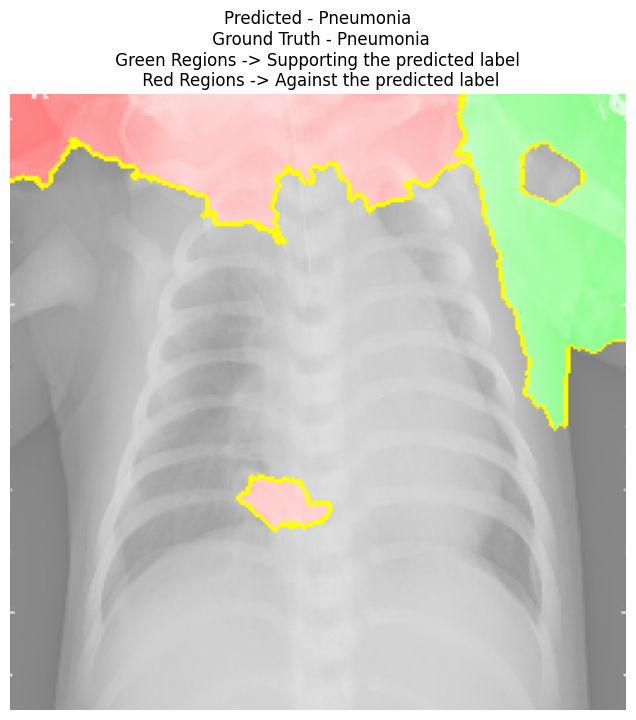

In [58]:
def explain_image(model, image, true_label, num_samples=1000, num_features=10):
    
    explanation = explainer.explain_instance(image.astype('double'), model.predict, top_labels=5, hide_color=0, num_samples=num_samples)
    
    # Get the mask for the predicted class
    pred_label = np.argmax(model.predict(np.expand_dims(image, axis=0)))
    temp, mask = explanation.get_image_and_mask(pred_label, positive_only=False, num_features=num_features, hide_rest=False)
    
    plt.figure(figsize=(8, 8))
    
    plt.imshow(mark_boundaries(temp / 2 + 0.5, mask))
    plt.title('Predicted - ' + ('Normal' if pred_label == 0 else 'Pneumonia') + 
              '\n Ground Truth - ' + ('Normal' if true_label == 0 else 'Pneumonia') + 
              '\n Green Regions -> Supporting the predicted label \n Red Regions -> Against the predicted label')
    plt.axis('off')  # Hide axes for better visibility
    plt.show()

# To use this function:
# Assuming you have test_images and test_labels from earlier provided snippets

# Example usage on the first image in the test set
index = 0
explain_image(model_with_attention, x_test_scaled[index], test_labels[index])

  0%|          | 0/1000 [00:00<?, ?it/s]

1/1 [==============================] - 2s 2s/step


  2%|▏         | 18/1000 [00:02<01:43,  9.48it/s]

1/1 [==============================] - 2s 2s/step


  3%|▎         | 28/1000 [00:04<02:29,  6.49it/s]

1/1 [==============================] - 2s 2s/step


  4%|▍         | 38/1000 [00:06<02:43,  5.88it/s]

1/1 [==============================] - 2s 2s/step


  4%|▍         | 42/1000 [00:09<04:29,  3.56it/s]

1/1 [==============================] - 2s 2s/step


  6%|▌         | 58/1000 [00:11<02:52,  5.46it/s]

1/1 [==============================] - 2s 2s/step


  6%|▌         | 62/1000 [00:13<03:59,  3.91it/s]

1/1 [==============================] - 2s 2s/step


  8%|▊         | 78/1000 [00:16<02:45,  5.58it/s]

1/1 [==============================] - 2s 2s/step


  8%|▊         | 82/1000 [00:18<04:01,  3.80it/s]

1/1 [==============================] - 2s 2s/step


  9%|▉         | 90/1000 [00:20<04:02,  3.76it/s]

1/1 [==============================] - 2s 2s/step


 11%|█         | 109/1000 [00:23<02:36,  5.70it/s]

1/1 [==============================] - 2s 2s/step


 11%|█▏        | 113/1000 [00:25<03:40,  4.03it/s]

1/1 [==============================] - 2s 2s/step


 12%|█▏        | 120/1000 [00:28<04:05,  3.58it/s]

1/1 [==============================] - 2s 2s/step


 14%|█▍        | 139/1000 [00:30<02:35,  5.52it/s]

1/1 [==============================] - 2s 2s/step


 14%|█▍        | 143/1000 [00:32<03:33,  4.00it/s]

1/1 [==============================] - 2s 2s/step


 16%|█▌        | 157/1000 [00:35<02:43,  5.16it/s]

1/1 [==============================] - 2s 2s/step


 17%|█▋        | 167/1000 [00:37<02:45,  5.03it/s]

1/1 [==============================] - 2s 2s/step


 17%|█▋        | 171/1000 [00:40<04:01,  3.44it/s]

1/1 [==============================] - 2s 2s/step


 19%|█▉        | 188/1000 [00:42<02:34,  5.25it/s]

1/1 [==============================] - 2s 2s/step


 19%|█▉        | 192/1000 [00:45<03:43,  3.61it/s]

1/1 [==============================] - 2s 2s/step


 20%|██        | 200/1000 [00:47<03:47,  3.52it/s]

1/1 [==============================] - 2s 2s/step


 22%|██▏       | 216/1000 [00:50<02:39,  4.91it/s]

1/1 [==============================] - 2s 2s/step


 23%|██▎       | 228/1000 [00:52<02:26,  5.28it/s]

1/1 [==============================] - 2s 2s/step


 23%|██▎       | 232/1000 [00:55<03:39,  3.50it/s]

1/1 [==============================] - 2s 2s/step


 25%|██▍       | 247/1000 [00:58<02:34,  4.87it/s]

1/1 [==============================] - 2s 2s/step


 26%|██▌       | 257/1000 [01:00<02:28,  5.00it/s]

1/1 [==============================] - 2s 2s/step


 27%|██▋       | 268/1000 [01:02<02:18,  5.30it/s]

1/1 [==============================] - 2s 2s/step


 28%|██▊       | 279/1000 [01:05<02:14,  5.38it/s]

1/1 [==============================] - 2s 2s/step


 28%|██▊       | 283/1000 [01:07<03:16,  3.64it/s]

1/1 [==============================] - 2s 2s/step


 29%|██▉       | 290/1000 [01:10<03:30,  3.38it/s]

1/1 [==============================] - 2s 2s/step


 31%|███       | 309/1000 [01:12<02:01,  5.70it/s]

1/1 [==============================] - 2s 2s/step


 31%|███▏      | 313/1000 [01:14<02:47,  4.10it/s]

1/1 [==============================] - 2s 2s/step


 33%|███▎      | 327/1000 [01:16<02:08,  5.24it/s]

1/1 [==============================] - 2s 2s/step


 33%|███▎      | 331/1000 [01:19<02:58,  3.75it/s]

1/1 [==============================] - 2s 2s/step


 35%|███▍      | 347/1000 [01:21<02:00,  5.41it/s]

1/1 [==============================] - 2s 2s/step


 35%|███▌      | 351/1000 [01:23<02:47,  3.88it/s]

1/1 [==============================] - 2s 2s/step


 37%|███▋      | 368/1000 [01:26<01:50,  5.74it/s]

1/1 [==============================] - 2s 2s/step


 37%|███▋      | 372/1000 [01:28<02:36,  4.02it/s]

1/1 [==============================] - 2s 2s/step


 39%|███▉      | 388/1000 [01:30<01:51,  5.47it/s]

1/1 [==============================] - 2s 2s/step


 39%|███▉      | 392/1000 [01:33<02:34,  3.93it/s]

1/1 [==============================] - 2s 2s/step


 41%|████      | 408/1000 [01:35<01:48,  5.45it/s]

1/1 [==============================] - 2s 2s/step


 41%|████      | 412/1000 [01:37<02:31,  3.88it/s]

1/1 [==============================] - 2s 2s/step


 43%|████▎     | 427/1000 [01:40<01:49,  5.25it/s]

1/1 [==============================] - 2s 2s/step


 44%|████▍     | 438/1000 [01:42<01:45,  5.35it/s]

1/1 [==============================] - 2s 2s/step


 44%|████▍     | 442/1000 [01:45<02:34,  3.62it/s]

1/1 [==============================] - 2s 2s/step


 46%|████▌     | 459/1000 [01:47<01:36,  5.61it/s]

1/1 [==============================] - 2s 2s/step


 46%|████▋     | 463/1000 [01:49<02:14,  3.98it/s]

1/1 [==============================] - 2s 2s/step


 48%|████▊     | 477/1000 [01:52<01:41,  5.16it/s]

1/1 [==============================] - 2s 2s/step


 49%|████▉     | 488/1000 [01:54<01:33,  5.47it/s]

1/1 [==============================] - 2s 2s/step


 49%|████▉     | 492/1000 [01:57<02:21,  3.60it/s]

1/1 [==============================] - 2s 2s/step


 51%|█████     | 508/1000 [01:59<01:37,  5.06it/s]

1/1 [==============================] - 2s 2s/step


 51%|█████     | 512/1000 [02:02<02:16,  3.56it/s]

1/1 [==============================] - 2s 2s/step


 53%|█████▎    | 528/1000 [02:04<01:31,  5.14it/s]

1/1 [==============================] - 2s 2s/step


 54%|█████▍    | 538/1000 [02:07<01:34,  4.90it/s]

1/1 [==============================] - 2s 2s/step


 55%|█████▍    | 549/1000 [02:10<01:31,  4.95it/s]

1/1 [==============================] - 2s 2s/step


 55%|█████▌    | 553/1000 [02:12<02:11,  3.39it/s]

1/1 [==============================] - 2s 2s/step


 56%|█████▌    | 560/1000 [02:15<02:17,  3.20it/s]

1/1 [==============================] - 2s 2s/step


 58%|█████▊    | 578/1000 [02:17<01:22,  5.14it/s]

1/1 [==============================] - 2s 2s/step


 58%|█████▊    | 582/1000 [02:19<01:51,  3.77it/s]

1/1 [==============================] - 2s 2s/step


 60%|█████▉    | 598/1000 [02:22<01:17,  5.16it/s]

1/1 [==============================] - 2s 2s/step


 60%|██████    | 602/1000 [02:24<01:47,  3.69it/s]

1/1 [==============================] - 2s 2s/step


 62%|██████▏   | 619/1000 [02:27<01:11,  5.30it/s]

1/1 [==============================] - 2s 2s/step


 62%|██████▏   | 623/1000 [02:29<01:39,  3.80it/s]

1/1 [==============================] - 2s 2s/step


 64%|██████▍   | 638/1000 [02:32<01:10,  5.12it/s]

1/1 [==============================] - 2s 2s/step


 64%|██████▍   | 642/1000 [02:34<01:37,  3.69it/s]

1/1 [==============================] - 2s 2s/step


 66%|██████▌   | 658/1000 [02:37<01:05,  5.25it/s]

1/1 [==============================] - 2s 2s/step


 66%|██████▌   | 662/1000 [02:39<01:30,  3.73it/s]

1/1 [==============================] - 2s 2s/step


 67%|██████▋   | 670/1000 [02:42<01:32,  3.56it/s]

1/1 [==============================] - 2s 2s/step


 68%|██████▊   | 680/1000 [02:44<01:26,  3.72it/s]

1/1 [==============================] - 2s 2s/step


 69%|██████▉   | 690/1000 [02:47<01:21,  3.82it/s]

1/1 [==============================] - 2s 2s/step


 70%|███████   | 700/1000 [02:49<01:16,  3.91it/s]

1/1 [==============================] - 2s 2s/step


 71%|███████   | 710/1000 [02:51<01:11,  4.06it/s]

1/1 [==============================] - 2s 2s/step


 72%|███████▏  | 720/1000 [02:54<01:07,  4.18it/s]

1/1 [==============================] - 2s 2s/step


 73%|███████▎  | 730/1000 [02:56<01:04,  4.18it/s]

1/1 [==============================] - 2s 2s/step


 74%|███████▍  | 740/1000 [02:58<01:00,  4.31it/s]

1/1 [==============================] - 2s 2s/step


 75%|███████▌  | 750/1000 [03:00<00:57,  4.37it/s]

1/1 [==============================] - 2s 2s/step


 77%|███████▋  | 768/1000 [03:03<00:39,  5.83it/s]

1/1 [==============================] - 2s 2s/step


 77%|███████▋  | 771/1000 [03:05<00:56,  4.05it/s]

1/1 [==============================] - 2s 2s/step


 78%|███████▊  | 780/1000 [03:07<00:54,  4.01it/s]

1/1 [==============================] - 2s 2s/step


 79%|███████▉  | 790/1000 [03:10<00:50,  4.17it/s]

1/1 [==============================] - 3s 3s/step


 81%|████████  | 808/1000 [03:12<00:35,  5.37it/s]

1/1 [==============================] - 2s 2s/step


 82%|████████▏ | 819/1000 [03:15<00:33,  5.35it/s]

1/1 [==============================] - 2s 2s/step


 82%|████████▏ | 823/1000 [03:18<00:48,  3.62it/s]

1/1 [==============================] - 3s 3s/step


 84%|████████▍ | 838/1000 [03:21<00:34,  4.76it/s]

1/1 [==============================] - 2s 2s/step


 84%|████████▍ | 842/1000 [03:23<00:45,  3.48it/s]

1/1 [==============================] - 2s 2s/step


 86%|████████▌ | 858/1000 [03:26<00:28,  4.95it/s]

1/1 [==============================] - 2s 2s/step


 86%|████████▌ | 862/1000 [03:28<00:38,  3.55it/s]

1/1 [==============================] - 2s 2s/step


 87%|████████▋ | 870/1000 [03:31<00:38,  3.41it/s]

1/1 [==============================] - 2s 2s/step


 88%|████████▊ | 880/1000 [03:33<00:32,  3.64it/s]

1/1 [==============================] - 2s 2s/step


 89%|████████▉ | 890/1000 [03:35<00:28,  3.83it/s]

1/1 [==============================] - 2s 2s/step


 91%|█████████ | 909/1000 [03:38<00:16,  5.46it/s]

1/1 [==============================] - 2s 2s/step


 91%|█████████▏| 913/1000 [03:40<00:21,  4.00it/s]

1/1 [==============================] - 2s 2s/step


 92%|█████████▏| 920/1000 [03:43<00:21,  3.65it/s]

1/1 [==============================] - 2s 2s/step


 93%|█████████▎| 930/1000 [03:45<00:18,  3.86it/s]

1/1 [==============================] - 2s 2s/step


 95%|█████████▍| 946/1000 [03:47<00:10,  5.12it/s]

1/1 [==============================] - 2s 2s/step


 96%|█████████▌| 958/1000 [03:50<00:07,  5.58it/s]

1/1 [==============================] - 2s 2s/step


 96%|█████████▌| 962/1000 [03:52<00:09,  3.87it/s]

1/1 [==============================] - 2s 2s/step


 98%|█████████▊| 979/1000 [03:55<00:03,  5.76it/s]

1/1 [==============================] - 2s 2s/step


 98%|█████████▊| 983/1000 [03:57<00:04,  4.06it/s]

1/1 [==============================] - 2s 2s/step


 99%|█████████▉| 990/1000 [03:59<00:02,  3.65it/s]

1/1 [==============================] - 2s 2s/step


100%|██████████| 1000/1000 [04:01<00:00,  4.13it/s]
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


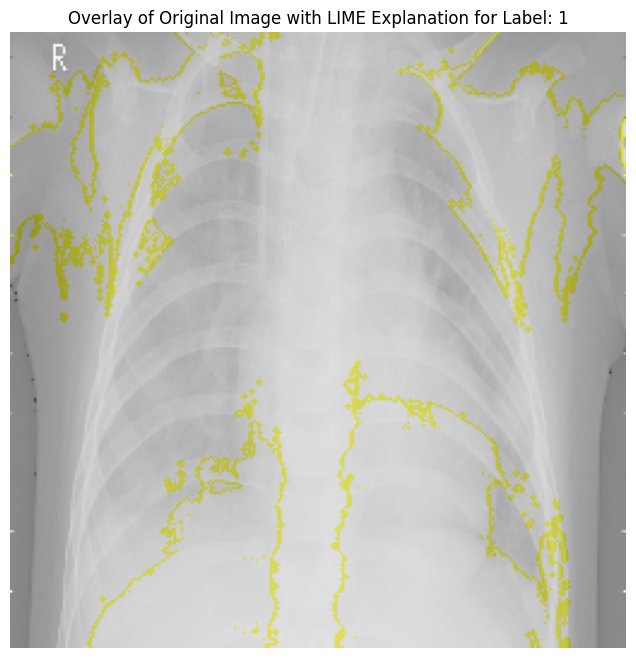

In [50]:


def explain_image_using_lime(model, image, label, num_features=10, num_samples=1000):
    
    explanation = explainer.explain_instance(image.astype('double'), model.predict, top_labels=5, num_samples=num_samples)
    temp, mask = explanation.get_image_and_mask(label, positive_only=True, num_features=num_features, hide_rest=False)
    
    # Create an overlay image
    fig, ax = plt.subplots(figsize=(8, 8))
    ax.imshow(image.astype('uint8'))
    ax.imshow(mark_boundaries(temp / 2 + 0.5, mask), alpha=0.5)  # Overlay with transparency
    ax.axis('off')
    plt.title(f'Overlay of Original Image with LIME Explanation for Label: {label}')
    plt.show()


index = 1 
explain_image_using_lime(model_with_attention, test_images[index], test_labels[index])